# Suncal API User Manual: Uncertainty Propagation Calculations

This notebook outlines use of suncal for determining uncertainty in a measurement model using both GUM and Monte Carlo methods.
A measurement model mathematically defined by $y = f(x_1, x_2, ...)$, where the uncertianty each $x_n$ is known, and the uncertainty $u(y)$ in the output $y$ is to be calculated. A model may also contain multiple functions sharing the same input variables.

In suncal, the model may be a string expression, a sympy expression, or any Python callable, as described below.
A Type A uncertainty and any number of Type B uncertainties may be defined for each variable in the model.

In [1]:
import suncal

## Measurement Models

Start by defining the basic measurement model using `suncal.Model`. Input variables are defined using `var()` to access the variable by name, then `measure` to provide the measured or expected value. Type B uncertainties are added using the `typeb()` method on each variable.

The `calculate()` method calculates uncertainty using both GUM and Monte Carlo methods.

In [2]:
model = suncal.Model('R = V/I')
model.var('V').measure(100).typeb(unc=1, k=2)
model.var('I').measure(2).typeb(unc=.01, k=2)
model.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$R$   | GUM          | 50.00  | 0.28           | ± 0.55     | 1.960     | inf           |
|$R$   | Monte Carlo  | 50.00  | 0.28           | (49.45, 50.55) | 1.963     | -             |

## Input Variable Uncertainties

### Type A Uncertainties

Often a variable will be determined by the mean of a series of measurements, leading to a Type A uncertainty. Type A uncertainties are calculated automatically when the `measure()` method recieves a list or array of values.
Here is a direct measurement (single input variable) with only Type A uncertainty.

In [3]:
model = suncal.Model('f = V')
model.var('V').measure([100, 101, 103, 99, 100, 101, 101])
model.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$f$   | GUM          | 100.71  | 0.47           | ± 1.2     | 2.447     | 6.0           |
|$f$   | Monte Carlo  | 100.71  | 0.47           | (99.79, 101.64) | 1.959     | -             |

### Type B Uncertainties

Type B uncertainties may be added to the variable using the `typeb` method, which takes arguments specifying the probability distribution to use. Type B uncertainties are given normal distributions by default, and they may be specified using `std` for standard uncertainty, or `unc` and `k` to specify an uncertainty at another coverage factor.

The `typeb` and `measure` methods return an instance of the variable, so the function calls may be chained together for readability.

In [4]:
model = suncal.Model('f = V')
model.var('V').measure(100).typeb(unc=2, k=2)
model.calculate_gum()

|Function   | Nominal   | Std. Uncertainty  |
|----------|---------|------------------|
|$f$   | 100.0  | 1.0          |

In [5]:
model = suncal.Model('f = V')
model.var('V').measure(100).typeb(std=1)
model.calculate_gum()

|Function   | Nominal   | Std. Uncertainty  |
|----------|---------|------------------|
|$f$   | 100.0  | 1.0          |

Other distributions are available by providing the `dist` parameter. Here, a uniform distribution is supplied, with half-width `a`. Notice the standard uncertainty becomes $\frac{a}{\sqrt{3}}$

In [6]:
model = suncal.Model('f = V')
model.var('V').measure(100).typeb(dist='uniform', a=1)
model.calculate_gum()

|Function   | Nominal   | Std. Uncertainty  |
|----------|---------|------------------|
|$f$   | 100.00  | 0.58          |

The dist name must be an available distribution in the scipy.stats module, and in general, parameters match the parameters required to define the scipy.stats instance.

Multiple Type B uncertainties may be cascaded to account for things like equipment accuracy, resolution, temperature effects, etc. Each Type B can be provided a name for record keeping purposes.

In [7]:
model = suncal.Model('f = V')
model.var('V').measure([100, 101, 103, 99, 100, 101, 101]).typeb(name='accuracy', unc=.5).typeb(name='resolution', unc=.5)
result = model.calculate()
result.report.variables.components()

|Variable   | Component   | Standard Uncertainty   | Deg. Freedom   | Description                            |
|----------|-----------|----------------------|--------------|---------------------------------------|
|$V$   | -           | -                      | -              |                                        |
|-          | Type A      | 0.47               | 6.0       | Type A uncertainty from 7 measurements |
|-          | accuracy    | 0.50               | inf       |                                        |
|-          | resolution  | 0.50               | inf       |                                        |

## Calculating Results

Sometimes, only one or the other method is needed. Use `suncal.Model.calculate_gum()` or `suncal.Model.monte_carlo()` to run the specific calculation. Notice the results only include one method, but in this case, are identical.

In [8]:
model = suncal.Model('R = V/I')
model.var('V').measure(100).typeb(unc=1, k=2)
model.var('I').measure(2).typeb(unc=.01, k=2)
model.calculate_gum()

|Function   | Nominal   | Std. Uncertainty  |
|----------|---------|------------------|
|$R$   | 50.00  | 0.28          |

In [9]:
model.monte_carlo()

|Function   | Nominal   | Std. Uncertainty  |
|----------|---------|------------------|
|$R$   | 50.00  | 0.28          |

## Results

The calculation methods return results objects whose type depends on the calculation. Read the docstring for the results instance to see all the available parameters.

In [10]:
results = model.calculate_gum()
print(results.__doc__)

 Results of GUM uncertainty calculation

        Attributes:
            uncertainty (dict): Computed standard uncertainties for each model function
            expected (dict): Computed expected/mean values for each model function
            Uy (list): Covariance matrix of model functions
            Ux (list): Covariance matrix of model input variables
            Cx (list): Sensitivity matrix
            degf (dict): Effective degrees of freedom for each model function
            functions (list): The model functions as Sympy expressions
            symbolic (tuple): Symbolic expressions for uncertainty, Uy, Ux, Cx, and degf
            variables (tuple): Information about the input variables and uncertainties
            warns (list): Any warnings generated during the calculation
            descriptions (dict): Descriptions of model functions
            report (Report): Generate formatted reports of the results

        Methods:
            units: Convert the units of uncertain

For example, to access the computed uncertainty and expected value:

In [11]:
results.uncertainty

{'R': 0.2795084971874737}

In [12]:
results.expected

{'R': 50.0}

Note these return dictionaries with the function name as dictionary key, to enable multi-variable measurement models.
The `symbolic` attribute of GUM results is useful to see what was calculated.

In [13]:
results.symbolic.uncertainty['u_R']

sqrt(u_V**2/I**2 + V**2*u_I**2/I**4)

The methods take additional parameters or perform computations on the results. For example, to compute expanded uncertainty at 99% confidence:

In [14]:
results.expanded(.99)

{'R': Expanded(uncertainty=0.7199661790206271, k=2.575829308465448, confidence=0.99)}

The Monte Carlo method results of course don't have all the same information. However, the random samples both in the variables and the computed model functions are available:

In [15]:
results = model.monte_carlo()
print(results.__doc__)

 Results of Monte Carlo uncertainty calculation

        Attributes:
            uncertainty (dict): Computed standard uncertainties for each model function
            expected (dict): Computed expected/mean values for each model function
            samples (dict): Random samples calculated for each model function
            varsamples (dict): Random samples generated for each input variable
            variables (tuple): Information about the input variables and uncertainties
            warns (list): Any warnings generated during the calculation
            descriptions (dict): Descriptions of model functions
            report (Report): Generate formatted reports of the results

        Methods:
            units: Convert the units of uncertainty and expected
            expand: Expand the uncertainty of a single function
            expanded: Get dictionary of expanded uncertainties for all model functions
            expect: Get a single expected value
            sensitivity: 

In [16]:
results.samples['R']

array([49.95799732, 50.05818004, 49.74172538, ..., 49.7164574 ,
       50.35736259, 49.35967475])

In [17]:
results.varsamples['V']

array([100.17102779, 100.06049976, 100.16031463, ...,  99.25481912,
       100.76765879,  98.32560913])

## Reports

The result objects contain a `Report` instance that is used to generate formatted reports and plots. `summary()` is the default report:

In [18]:
results = model.calculate()
results.report.summary()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$R$   | GUM          | 50.00  | 0.28           | ± 0.55     | 1.960     | inf           |
|$R$   | Monte Carlo  | 50.00  | 0.28           | (49.45, 50.55) | 1.961     | -             |

Other reports may be generated using other methods:

In [19]:
results.report.expanded()

### GUM Approximation


|Function   | Level of Confidence   | Minimum   | Maximum   | k         | Deg. Freedom   | Expanded Uncertainty  |
|----------|---------------------|---------|---------|---------|--------------|----------------------|
|$R$   | 95.00%                | 49  | 51  | 1.960     | inf            | 0.55              |


### Monte Carlo

Symmetric Coverage Intervals

|Function   | Level of Confidence   | Minimum   | Maximum   | Coverage Factor  |
|----------|---------------------|---------|---------|-----------------|
|$R$   | 95.00%                | 49  | 51  | 1.961            |

In [20]:
results.report.sensitivity()

|Variable   | GUM Sensitivity   | GUM Proportion   | MC Sensitivity   | MC Proportion  |
|----------|-----------------|----------------|----------------|---------------|
|$I$   | -25.0          | 20.00%           | 25.0         | 20.04%         |
|$V$   | 0.50          | 80.00%           | 0.50         | 80.08%         |

In [21]:
results.report.variables.components()

|Variable   | Component   | Standard Uncertainty   | Deg. Freedom   | Description  |
|----------|-----------|----------------------|--------------|-------------|
|$I$   | -           | -                      | -              |              |
|-          | Type B      | 0.0050               | inf       |              |
|$V$   | -           | -                      | -              |              |
|-          | Type B      | 0.50               | inf       |              |

The `report` contains a `plot` instance for generating plots, using Matplotlib:

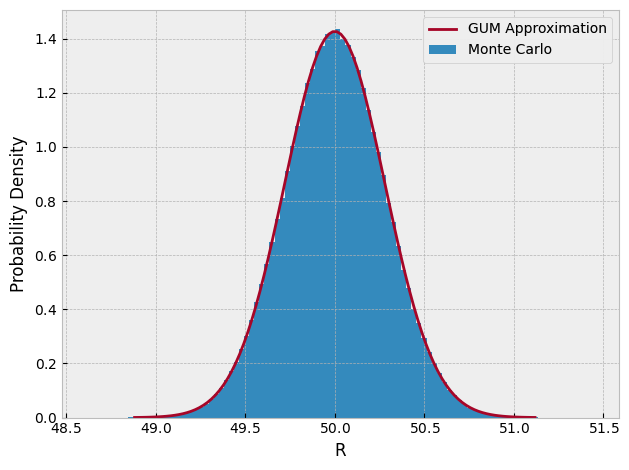

In [22]:
results.report.plot.pdf()

Separate reports for the GUM and Monte Carlo results can access other information.

In [23]:
results.gum.report.derivation()

### Measurement Model:

$R = \frac{V}{I}$

### Measured Values:


|Variable   | Std. Uncertainty   | Deg. Freedom  |
|----------|------------------|--------------|
|$I$   | $u_{I}$           | $\nu_{I}$      |
|$V$   | $u_{V}$           | $\nu_{V}$      |


### Combined Uncertainty:

$u_{R} = \sqrt{\frac{u_{V}^{2}}{I^{2}} + \frac{V^{2} u_{I}^{2}}{I^{4}}}$

### Effective degrees of freedom:

$\nu_{R} = \frac{u_{R}^{4}}{\frac{u_{V}^{4}}{I^{4} \nu_{V}} + \frac{V^{4} u_{I}^{4}}{I^{8} \nu_{I}}}$

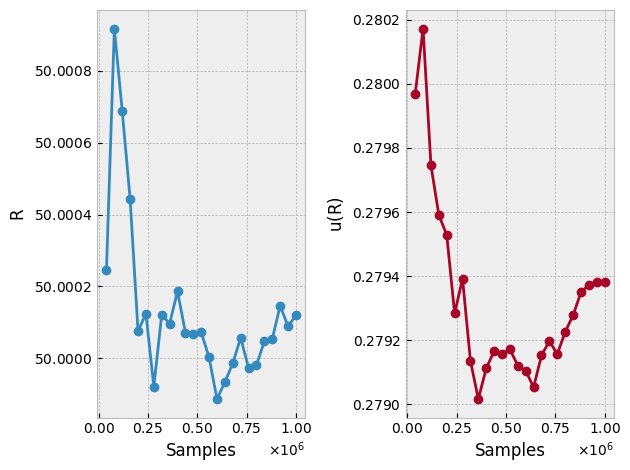

In [24]:
results.montecarlo.report.plot.converge()

Use the `help` function or class docstrings to explore all the available reports.

## Measurement Units

Suncal can handle calculations with measurement units. To define units, either supply Pint Quantities (using the Pint Python library), or supply unit names as strings (which will be converted to Pint quantities internally. The Type B uncertainties inherit units from the measured value, if not supplied separately.

Pint requires all calculations use the same "Unit Registry", so when supplying values as Pint Quantities, use the unit registry defined by suncal: `suncal.ureg`.

In [25]:
model = suncal.Model('R = V/I')
model.var('V').measure(100, units='volts').typeb(unc=1, k=2)
model.var('I').measure(2, units='ampere').typeb(unc=.01, k=2)
result = model.calculate()
result

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$R$   | GUM          | 50.00 V/A  | 0.28 V/A           | ± 0.55 V/A     | 1.960     | inf           |
|$R$   | Monte Carlo  | 50.00 V/A  | 0.28 V/A           | (49.45 V/A, 50.55 V/A) | 1.962     | -             |

In [26]:
model = suncal.Model('R = V/I')
model.var('V').measure(100*suncal.ureg.volts).typeb(unc=1, k=2)
model.var('I').measure(2*suncal.ureg.ampere).typeb(unc=.01, k=2)
result = model.calculate()
result

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$R$   | GUM          | 50.00 V/A  | 0.28 V/A           | ± 0.55 V/A     | 1.960     | inf           |
|$R$   | Monte Carlo  | 50.00 V/A  | 0.28 V/A           | (49.45 V/A, 50.55 V/A) | 1.962     | -             |

Notice the results are in units of volts/ampere, while you were probably expecting Ohms. Suncal (and Pint) don't have any unambiguous way of determining whether to convert units to something else, so they come out in the "natural" units of the calculation. The result object has a `units` method to define other compatible units to display. It takes keyword arguments of the function name and a string defining the unit. This way, units of the output results may be converted without re-running the calculation.

In [27]:
result.units(R='ohm')

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$R$   | GUM          | 50.00 Ω  | 0.28 Ω           | ± 0.55 Ω     | 1.960     | inf           |
|$R$   | Monte Carlo  | 50.00 Ω  | 0.28 Ω           | (49.45 Ω, 50.55 Ω) | 1.962     | -             |

## Joint Models

The `Model` class takes one or more string expressions as arguments, each defining one function of the model. For example, the resistance model used above may be extended to compute resistance and power simultaneously. The result and reports will have functions for viewing joint probability and correlations between the functions.

In [28]:
model = suncal.Model('R = V/I', 'P = V*I')
model.var('V').measure(100, units='volt').typeb(unc=1, k=2)
model.var('I').measure(2, units='amp').typeb(unc=.01, k=2)
result = model.calculate()
result.units(R='ohm', P='watt')

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$R$   | GUM          | 50.00 Ω  | 0.28 Ω           | ± 0.55 Ω     | 1.960     | inf           |
|$R$   | Monte Carlo  | 50.00 Ω  | 0.28 Ω           | (49.45 Ω, 50.55 Ω) | 1.959     | -             |
|$P$   | GUM          | 200.0 W  | 1.1 W           | ± 2.2 W     | 1.960     | inf           |
|$P$   | Monte Carlo  | 200.0 W | 1.1 W          | (197.8 W, 202.2 W) | 1.961     | -             |

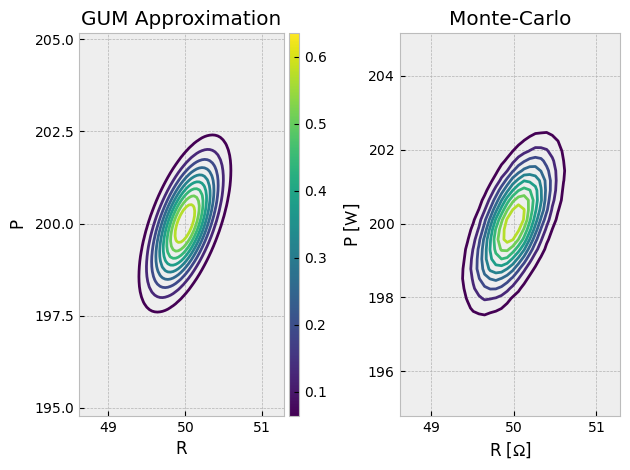

In [29]:
result.report.plot.joint_pdf()

In [30]:
result.gum.report.correlation()

### Correlation Coefficients


|-         | $R$  | $P$ |
|---------|---------|---------|
|$R$  | 1.000     | 0.600    |
|$P$  | 0.600     | 1.000    |

## Other Model Types

Above, we have seen models defined as equations in Python strings.
Suncal can also compute unceratinty of Sympy expressions, Python callable functions, and Complex-Numbered functions, as described below.

### Sympy Models

Sometimes a measurement model may be already defined as a Sympy expression. The `suncal.Model` can also take sympy expressions as arguments. When a string expressions is supplied as above, it will be "sympyfied" before calculating anyway, so the results are identical.

In [31]:
import sympy
x, y = sympy.symbols('x y')
expr = sympy.sqrt(x**2 + y**2)
expr

sqrt(x**2 + y**2)

In [32]:
model = suncal.Model(expr)
model.var('x').measure(0.01).typeb(std=0.01)
model.var('y').measure(0.01).typeb(std=0.01)
result = model.calculate()
result

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$f_{1}$   | GUM          | 0.014  | 0.010           | ± 0.020     | 1.960     | inf           |
|$f_{1}$   | Monte Carlo  | 0.0181  | 0.0084           | (0.0037, 0.0359) | 1.911     | -             |

## Python Callable Models

Some measurement models cannot be written as a simple string expression. Suncal can handle uncertainty calculation on any Python callable function, without needing a simple expression form. `suncal.ModelCallable` takes a Python function as input and computes the uncertainty. The only limitation is that symbolic results are not available (the partial derivatives for the sensitvity coefficients are computed by numeric approximation).

Below shows how a custom function may be passed to `suncal.ModelCallable`. Parameter names and the funciton name are automatically extracted.

In [33]:
def myfunc(a, b):
    return a * b + 10

model = suncal.ModelCallable(myfunc)
model.var('a').measure(24).typeb(std=.5)
model.var('b').measure(32).typeb(std=.5)
model.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$myfunc$   | GUM          | 778  | 20           | ± 39     | 1.960     | inf           |
|$myfunc$   | Monte Carlo  | 778  | 20           | (739, 818) | 1.962     | -             |

Multi-variate models may be used if they are returned as a tuple from a single function. Namedtuples work nicely to provide the result names.

In [34]:
from collections import namedtuple

def myfunc(a, b):
    MyFuncResult = namedtuple('MyFuncResult', 'output1 output2')
    return MyFuncResult(a * b + 10, a**2 * b)

model = suncal.ModelCallable(myfunc)
model.var('a').measure(24).typeb(std=.5)
model.var('b').measure(32).typeb(std=.5)
model.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$output_{1}$   | GUM          | 778  | 20           | ± 39     | 1.960     | inf           |
|$output_{1}$   | Monte Carlo  | 778  | 20           | (739, 818) | 1.960     | -             |
|$output_{2}$   | GUM          | 18430  | 820           | ± 1600     | 1.960     | inf           |
|$output_{2}$   | Monte Carlo  | 18440 | 820          | (16860, 20080) | 1.961     | -             |

Functions that take keyword arguments can be used, but the `argnames` parameter must be speficied so suncal knows what variables are expected.
If the function cannot process Pint Quantity objects (values with units), and you would like to handle units on the inputs, the `unitsin` and `unitsout` parameters can be specified, telling suncal what output units (`unitsout`) result when the input argements are in `unitsin`.

In [35]:
def myfunc2(**kwargs):
    X = list(kwargs.values())
    return sum(X) / len(X)

data = {'X1':2, 'X2':4, 'X3':6, 'X4':8}

model = suncal.ModelCallable(myfunc2, argnames=data.keys())  # Must specify names of keyword arguments
for i, xval in enumerate([2, 4, 6, 8]):
    model.var(f'X{i+1}').measure(xval).typeb(std=.2)
    
model.calculate()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$myfunc_{2}$   | GUM          | 5.00  | 0.10           | ± 0.20     | 1.960     | inf           |
|$myfunc_{2}$   | Monte Carlo  | 5.00  | 0.10           | (4.80, 5.20) | 1.959     | -             |

#### More notes on python callable functions

- Monte Carlo calculation will be much faster if the callable function is vectorizable. If not, the calculator will resort to calling the function N times in a loop.
- The partial derivatives used in the GUM calculation will be calculated numerically. Thus the symbolic results are not available for callable functions.
- Some callable functions won't work with Pint Quantities as inputs. For these, specify the `unitsin` and `unitsout` arguments to ModelCallable. See the **Inductance Nagaoka** example notebook.

### Complex Numbers

When measurement models involve complex numbers, care must be taken to ensure maintaining the correlations between real and imaginary components and conversion from real/imaginary to magnitude/phase space.
Suncal provides `suncal.ModelComplex` for models involving complex values. (Note complex models are not available in the GUI at this time.)

With complex models, the `measure` method takes both value and uncertainty as arguments. Only Normal distributions are supported currently, but the correlation between real and imaginary components may be specified. This calculation shows an uncertainty evaluation in real and imaginary components.

In [36]:
model = suncal.ModelComplex('f = a + b')
model.var('a').measure(3+2j, uncertainty=.25+.25j, correlation=.35)
model.var('b').measure(4-3j, uncertainty=.25+.25j, correlation=.35)
result = model.calculate()
result

|Function   | Method       | Nominal     | Standard Uncertainty   | Correlation  |
|----------|------------|-----------|----------------------|-------------|
|f          | GUM          | 7.00-1.00j  | ± 0.18+0.18j           | 0.3500       |
|f          | Monte Carlo  | 7.00-1.00j  | ± 0.18+0.18j           | 0.3492       |

If the results are desired in magnitude and phase format, provide `magphase=True` to the Model. This must be done when the model is created, so that appropriate functions may be added for converting real and imaginary into magnitude and phase while properly accounting for their uncertainties.

In [37]:
model = suncal.ModelComplex('f = a * b', magphase=True)
model.var('a').measure(3+2j, uncertainty=.25+.25j, correlation=.35)
model.var('b').measure(4-3j, uncertainty=.25+.25j, correlation=.35)
result = model.calculate()
result

|Function   | Method       | Nominal          | Standard Uncertainty   | Correlation  |
|----------|------------|----------------|----------------------|-------------|
|f          | GUM          | 18.03 ∠-3.2 rad  | ± 0.81 ∠2.3 rad        | 0.1227       |
|f          | Monte Carlo  | 18.04 ∠-3.2 rad  | ± 0.81 ∠2.3 rad        | 0.1231       |

If degrees are preferred instead of radians:

In [38]:
result.degrees(True)

|Function   | Method       | Nominal       | Standard Uncertainty   | Correlation  |
|----------|------------|-------------|----------------------|-------------|
|f          | GUM          | 18.03 ∠-3.2°  | ± 0.81 ∠2.3°           | 0.1227       |
|f          | Monte Carlo  | 18.04 ∠-3.2°  | ± 0.81 ∠2.3°           | 0.1231       |

Finally, if the measured values are also given in magnitude and phase, they must be appropriately converted to real and imaginary to handle the statistics. Suncal provides the `measure_magphase` method to define variables:

In [39]:
model = suncal.ModelComplex('f = a + b', magphase=True)
model.var('a').measure_magphase(magnitude=0.95, phase=45, degrees=True, umagnitude=.05, uphase=5)
model.var('b').measure_magphase(magnitude=0.95, phase=45, degrees=True, umagnitude=.05, uphase=5)
result = model.calculate()

Internally, Suncal splits each model function, and each model variable, into a real part and imaginary part, with appropriate correlations applied. The normal GUM and Monte Carlo methods are computed on the split functions, then the results are recombined. Because every function and variable becomes multiple model equations, the calculations can become slow. To see the full calculation, use `result.report.fullreport`.

In [40]:
result.report.fullreport.variables

|Variable   | Mean      | Std. Uncertainty   | Deg. Freedom   | Description  |
|----------|---------|------------------|--------------|-------------|
|$a_{deg}$   | 0.785  | 0.044           | inf       |              |
|$a_{mag}$   | 0.950  | 0.025           | inf       |              |
|$b_{deg}$   | 0.785  | 0.044           | inf       |              |
|$b_{mag}$   | 0.950  | 0.025          | inf      |              |

In [41]:
result.report.fullreport.summary()

|Function   | Method       | Nominal   | Std. Uncertainty   | 95% Coverage   | k         | Deg. Freedom  |
|----------|------------|---------|------------------|--------------|---------|--------------|
|$f_{mag}$   | GUM          | 1.900  | 0.035           | ± 0.069     | 1.960     | inf           |
|$f_{mag}$   | Monte Carlo  | 1.900  | 0.035           | (1.831, 1.969) | 1.959     | -             |
|$f_{rad}$   | GUM          | 0.01371  | 0.00054           | ± 0.0011     | 1.960     | inf           |
|$f_{rad}$   | Monte Carlo  | 0.01371 | 0.00054          | (0.01265, 0.01476) | 1.958     | -             |

## Plotting

Plots are generated with Matplotlib. They may be re-styled using matplotlib themes.

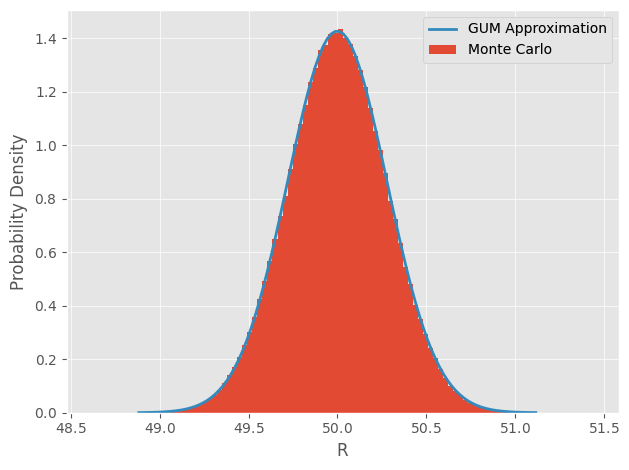

In [42]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
results.report.plot.pdf()

Keyword arguments to the suncal plot functions are passed to the matplotlib plot methods.

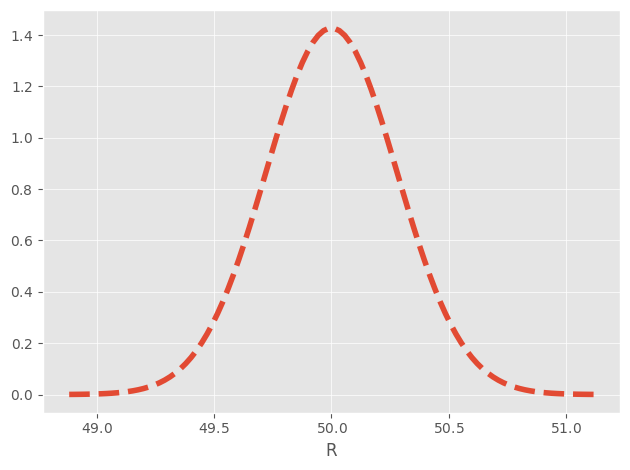

In [43]:
results.gum.report.plot.pdf(ls='--', linewidth=4)

## Probability Distributions

Any distribution implemented by the scipy.stats module can be used in the `typeb` method.
(See http://docs.scipy.org/doc/scipy/reference/stats.html)
Custom distributions can also be implemented by subclassing rv_continuous or rv_discrete.
See Curvilinear Trapezoidal distribution in suncal/common/distributions.py for an example of subclassing.

Below are examples of how to set up some common distributions in the `typeb` method.

In [44]:
from suncal.uncertainty.variables import Typeb

plt.rcParams['figure.figsize'] = (4, 3)

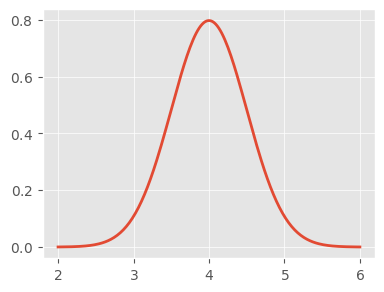

In [45]:
u = Typeb(dist='normal', nominal=4, std=0.5)
x, y = u.pdf()
plt.plot(x, y);

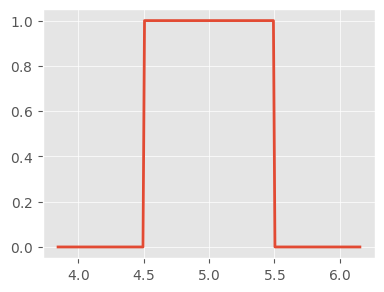

In [46]:
u = Typeb(dist='uniform', nominal=5, a=0.5)
x, y = u.pdf()
plt.plot(x, y);

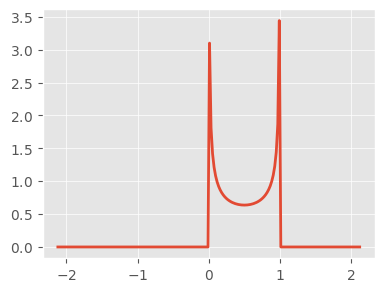

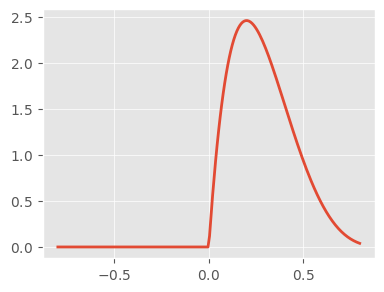

In [47]:
# Beta, parameters a and b
u = Typeb(dist='beta', a=.5, b=.5)
x, y = u.pdf(stds=6)
plt.plot(x, y);

plt.figure()
u = Typeb(dist='beta', a=2, b=5)
x, y = u.pdf(stds=5)
plt.plot(x, y);

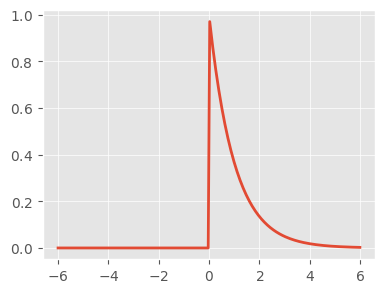

In [48]:
# Exponential, parameters loc and scale
u = Typeb(dist='expon', loc=5, scale=2)
x, y = u.pdf(stds=6)
plt.plot(x, y);

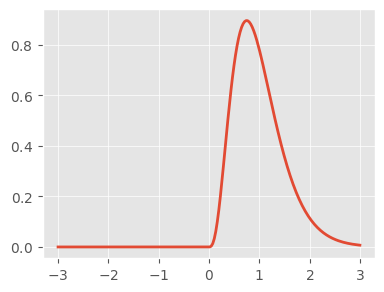

In [49]:
# Gamma, parameter alpha and beta (shape)
u = Typeb(dist='gamma', alpha=4, beta=4)
x, y = u.pdf(stds=6)
plt.plot(x, y);

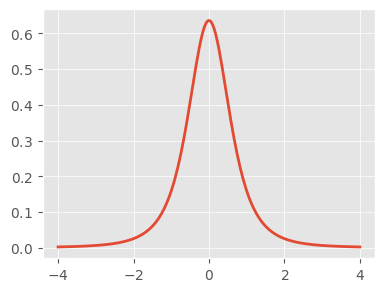

In [50]:
# Student's T,
u = Typeb(dist='t', unc=1, df=3)
x, y = u.pdf()
plt.plot(x, y);

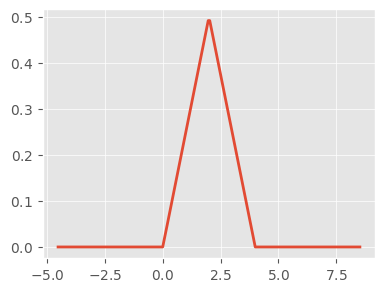

In [51]:
# Triangular, symmetric
u = Typeb(dist='triangular', nominal=2, a=2)
x, y = u.pdf(stds=8)
plt.plot(x, y);

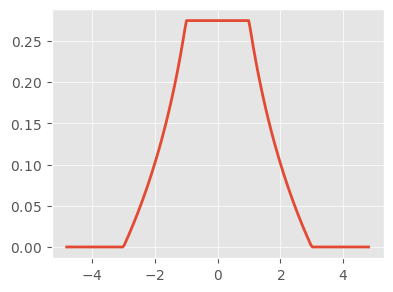

In [52]:
# Curvilinear Trapezoid (See GUM-Supplement 1)
u = Typeb(dist='curvtrap', a=2, d=1)
x, y = u.pdf(stds=4)
plt.plot(x, y);